In [23]:
%load_ext autoreload
from ddls.plotting.plotting import PlotAesthetics
from ddls.environments.ramp_cluster.utils import load_ramp_cluster_environment_metrics_from_wandb_run

from collections import defaultdict
from sqlitedict import SqliteDict
import pprint
import glob
import os
import time
import pandas as pd
import numpy as np
import scipy.stats as st
import sigfig

import gzip
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
job_to_overhead_dict = defaultdict(list)

for job in range(1, 7):
    job_to_overhead_dict['Job'].extend([f'Job {job}' for _ in range(5)])
    job_to_overhead_dict['\# Workers'].extend([8, 16, 32, 64, 128])

job_to_overhead_dict['Network Overhead (\%)'].extend([1, 20, 30, 40, 50])
job_to_overhead_dict['Network Overhead (\%)'].extend([1, 10, 21, 56, 57])
job_to_overhead_dict['Network Overhead (\%)'].extend([1, 20, 21, 23, 41])
job_to_overhead_dict['Network Overhead (\%)'].extend([1, 22, 38, 46, 59])
job_to_overhead_dict['Network Overhead (\%)'].extend([1, 20, 31, 40, 50])
job_to_overhead_dict['Network Overhead (\%)'].extend([1, 36, 43, 55, 61])

df = pd.DataFrame(job_to_overhead_dict)
display(df)

,Job,\# Workers,Network Overhead (\%)
0,Job 1,8,1
1,Job 1,16,20
2,Job 1,32,30
3,Job 1,64,40
4,Job 1,128,50
5,Job 2,8,1
6,Job 2,16,10
7,Job 2,32,21
8,Job 2,64,56
9,Job 2,128,57


In [25]:
aesthetics = PlotAesthetics()
aesthetics.set_icml_paper_plot_aesthetics() # paper training curve

estimator = np.mean # np.mean np.median

scaling_factor = 1
width_scaling_factor = 1
# height_scaling_factor = 1
height_scaling_factor = 0.65

xaxis = '\# Workers'

hue = 'Job'

# style = None
style = 'Job'

# markers = False
markers = True

legend = 'auto'

xaxis_label_style = 'sci' # sci plain
yaxis_label_style = 'plain' # sci plain

ylog = False
xlog = True


def lineplot(df, metric):
    print(f'Plotting metric {metric} -> min={np.min(df[metric])} | max={np.max(df[metric])} | mean={np.mean(df[metric])}')
    f, ax = plt.subplots(figsize=aesthetics.get_standard_fig_size(scaling_factor=scaling_factor, width_scaling_factor=width_scaling_factor, height_scaling_factor=height_scaling_factor))
    g = sns.lineplot(data=df, 
                     x=xaxis, 
                     y=metric, 
                     hue=hue, 
                     style=style,
                     markers=markers,
                     linewidth=aesthetics.linewidth,
                     legend=legend)
    handles, lables = g.get_legend_handles_labels()
    for h in handles:
        h.set_markersize(2)
        h.set_linewidth(aesthetics.linewidth)
    # ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.275), ncol=3, labelspacing=0.1, columnspacing=6, prop={'size': 6})
    # ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=6, labelspacing=2, columnspacing=2, prop={'size': 4.25})
    ax.legend(loc='upper center', 
                  bbox_to_anchor=(0.5, 1.275), 
                  ncol=3, 
                  labelspacing=0.1, 
                  columnspacing=6, 
                  prop={'size': 6},
                  title=None,
                  frameon=False,
                 )
    
    ax.tick_params(axis='both', which='major', pad=2)
    ax.xaxis.labelpad = 2
    ax.yaxis.labelpad = 2
    sns.despine(ax=ax) # remove top and right spines
    g.ticklabel_format(style=xaxis_label_style, axis='x', scilimits=(0,0))
    g.ticklabel_format(style=yaxis_label_style, axis='y', scilimits=(0,0))
    if xlog:
        g.set(xscale='log')
    if ylog:
        g.set(yscale='log')
    plt.gcf().patch.set_alpha(0.0)
    plt.show()

Plotting metric Network Overhead (\%) -> min=1 | max=61 | mean=29.866666666666667


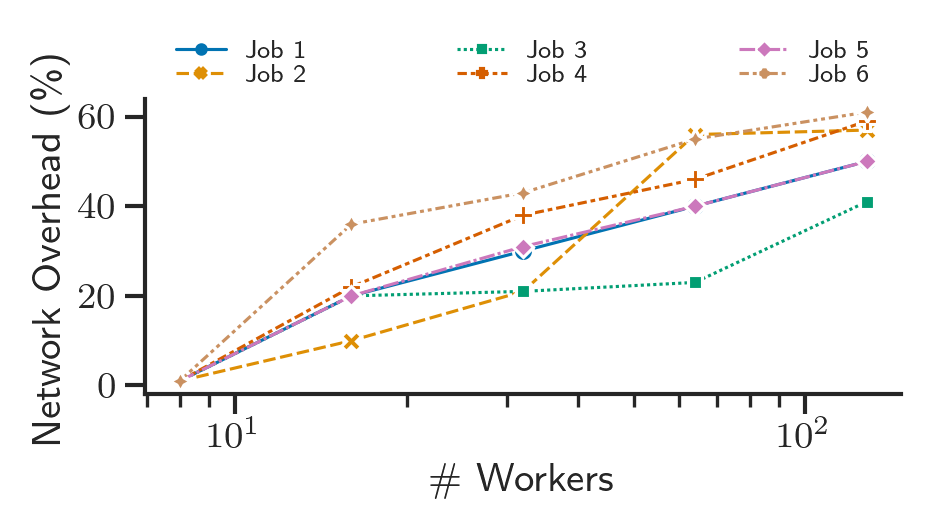

In [26]:
metrics = ['Network Overhead (\%)']
for metric in metrics:
    lineplot(df=df, metric=metric)

# Compare to RAMP (approximate)

In [27]:
########################### get mean network overhead from Meta cluster given in TopoOpt paper intro ###################################
topoopt_grouped_by_workers = df.groupby(['\# Workers'])['Network Overhead (\%)']
comparison_dict = defaultdict(list)
for key, item in topoopt_grouped_by_workers:
    print(f'\n# Workers: {key}')
    print(f'Network overheads across {len(item)} jobs:\n{item}')
    print(f'Mean network overhead: {item.mean()} (min: {item.min()} | max: {item.max()})')
    comparison_dict['\# Workers'].append(key)
    comparison_dict['Network Overhead (\%)'].append(item.mean())
    comparison_dict['Cluster'].append('Meta')


# Workers: 8
Network overheads across 6 jobs:
0     1
5     1
10    1
15    1
20    1
25    1
Name: Network Overhead (\%), dtype: int64
Mean network overhead: 1.0 (min: 1 | max: 1)

# Workers: 16
Network overheads across 6 jobs:
1     20
6     10
11    20
16    22
21    20
26    36
Name: Network Overhead (\%), dtype: int64
Mean network overhead: 21.333333333333332 (min: 10 | max: 36)

# Workers: 32
Network overheads across 6 jobs:
2     30
7     21
12    21
17    38
22    31
27    43
Name: Network Overhead (\%), dtype: int64
Mean network overhead: 30.666666666666668 (min: 21 | max: 43)

# Workers: 64
Network overheads across 6 jobs:
3     40
8     56
13    23
18    46
23    40
28    55
Name: Network Overhead (\%), dtype: int64
Mean network overhead: 43.333333333333336 (min: 23 | max: 56)

# Workers: 128
Network overheads across 6 jobs:
4     50
9     57
14    41
19    59
24    50
29    61
Name: Network Overhead (\%), dtype: int64
Mean network overhead: 53.0 (min: 41 | max: 61)


In [28]:
####################### get RAMP network overhead across same number of workers ##########################################
ramp_num_workers_to_run_path = {
    # # old
    # 8: 'ong/ddls/w6usu3qw',
    # 16: 'ong/ddls/3fhrbwoh',
    # 32: 'ong/ddls/dvg64acz',
    # 64: 'ong/ddls/1fww2dtc',
    # 128: 'ong/ddls/nxt6b2rg',
    
    # new
    8: 'ong/ddls/pu5q09z0',
    16: 'ong/ddls/2pn1tt0l',
    32: 'ong/ddls/sybmtrfr',
    64: 'ong/ddls/190bfb1n',
    128: 'ong/ddls/3ljzqvow',
    
}

keys_to_ignore = ['valid/step_stats/'] # for ignoring data not needed for plotting
key_substrings_to_remove = ['valid/episode_stats/'] # for tidying up keys
agent_to_episode_stats_dict, agent_to_episode_completion_stats_dict, agent_to_episode_blocked_stats_dict = load_ramp_cluster_environment_metrics_from_wandb_run(ramp_num_workers_to_run_path, keys_to_ignore=keys_to_ignore, key_substrings_to_remove=key_substrings_to_remove)

# convert dicts to dataframes
print(f'\nEpisode stats:')
for key, val in agent_to_episode_stats_dict.items():
    print(f'key {key} -> {len(val)} vals')
episode_stats_df = pd.DataFrame(agent_to_episode_stats_dict)
display(episode_stats_df)

episode_completion_stats_df = pd.DataFrame(agent_to_episode_completion_stats_dict)
display(episode_completion_stats_df)

episode_blocked_stats_df = pd.DataFrame(agent_to_episode_blocked_stats_dict)
display(episode_blocked_stats_df)


Recorded keys: {'valid/episode_stats/job_computation_overhead_time', 'valid/episode_stats/jobs_completed_max_acceptable_job_completion_time_frac', 'valid/episode_stats/compute_info_processed', 'valid/episode_stats/jobs_completed_max_acceptable_job_completion_time', 'valid/episode_stats/episode_start_time', 'valid/episode_stats/flow_info_processed', 'valid/episode_stats/mean_flow_throughput', 'valid/episode_stats/jobs_completed_total_operation_memory_cost', 'valid/episode_stats/num_jobs_arrived', 'valid/episode_stats/num_jobs_blocked', 'valid/episode_stats/job_completion_time_speedup', 'valid/episode_stats/jobs_completed_total_dependency_size', 'valid/episode_stats/demand_compute_info_processed', 'valid/episode_stats/mean_demand_total_throughput', 'valid/episode_stats/jobs_completed_original_demand_num_edges', 'valid/episode_stats/job_communication_overhead_time', 'valid/episode_stats/demand_dep_info_processed', 'valid/episode_stats/episode_time', 'valid/episode_stats/demand_total_info

,dep_info_processed,num_jobs_arrived,blocking_rate,episode_end_time,mean_demand_total_throughput,compute_info_processed,num_jobs_blocked,mean_demand_compute_throughput,episode_time,demand_dep_info_processed,...,acceptance_rate,episode_start_time,mean_flow_throughput,demand_total_info_processed,mean_dep_throughput,cluster_info_processed,mean_compute_throughput,mean_load_rate,mean_cluster_throughput,Agent
0,331722975184,5,0,400559.001880,394003.528138,78261259040,0,195380.102988,400559.001880,79560400928,...,1,0,8.011571e+05,157821659968,8.281501e+05,409984234224,195380.102988,308850.823808,1.023530e+06,8
1,614695048144,5,0,400279.583329,394278.565635,78261259040,0,195516.489722,400279.583329,79560400928,...,1,0,1.521734e+06,157821659968,1.535664e+06,692956307184,195516.489722,308850.823808,1.731181e+06,16
2,1180639194064,5,0,400140.008008,394416.096390,78261259040,0,195584.689043,400140.008008,79560400928,...,1,0,2.943174e+06,157821659968,2.950565e+06,1258900453104,195584.689043,308850.823808,3.146150e+06,32
3,2312527485904,5,0,400070.159900,394484.957357,78261259040,0,195618.836105,400070.159900,79560400928,...,1,0,5.776184e+06,157821659968,5.780305e+06,2390788744944,195618.836105,308850.823808,5.975924e+06,64
4,4576304069584,5,0,400035.233259,394519.399410,78261259040,0,195635.915373,400035.233259,79560400928,...,1,0,1.143727e+07,157821659968,1.143975e+07,4654565328624,195635.915373,308850.823808,1.163539e+07,128


,jobs_completed_max_partitions_per_op,job_communication_overhead_time,jobs_completed_original_demand_num_nodes,jobs_completed_num_edges,job_computation_overhead_time,jobs_completed_max_acceptable_job_completion_time_frac,jobs_completed_original_demand_total_operation_memory_cost,jobs_completed_max_acceptable_job_completion_time,jobs_completed_job_sequential_completion_time,jobs_completed_original_demand_num_edges,jobs_completed_num_nodes,jobs_completed_original_demand_total_dependency_size,job_completion_time,jobs_completed_total_dependency_size,job_completion_time_speedup,jobs_completed_total_operation_memory_cost,jobs_completed_num_mounted_channels,jobs_completed_mean_mounted_worker_utilisation_frac,jobs_completed_num_mounted_workers,Agent
0,8,2.313552,100.4,6467.8,3743.156501,0.638,15652251808,19593.4277,29945.16,111.8,635.2,1.591208e+10,3745.153795,6.634460e+10,7.996025,15652251808,56,896847.003832,8,8
1,16,2.422547,100.4,25803.8,1871.578332,0.638,15652251808,19593.4277,29945.16,111.8,1246.4,1.591208e+10,1873.697159,1.229390e+11,15.983218,15652251808,240,447645.627987,16,16
2,32,4.559345,100.4,103106.2,935.792082,0.638,15652251808,19593.4277,29945.16,111.8,2468.8,1.591208e+10,939.804882,2.361278e+11,31.873769,15652251808,992,224449.311892,32,32
3,64,4.694348,100.4,412232.6,467.896122,0.638,15652251808,19593.4277,29945.16,111.8,4913.6,1.591208e+10,472.040499,4.625055e+11,63.482539,15652251808,4032,112703.965122,64,64
4,128,4.714223,100.4,1648571.8,233.948142,0.638,15652251808,19593.4277,29945.16,111.8,9803.2,1.591208e+10,238.120170,9.152608e+11,125.943987,15652251808,16256,56808.199071,128,128


,Agent


In [29]:
# add ramp data to comparison dict
ramp_num_workers_to_network_overhead = defaultdict(list)
ramp_grouped_by_workers = episode_completion_stats_df.groupby(['Agent'])
for key, item in ramp_grouped_by_workers:
    print(f'\n# Workers: {key}')
    network_overhead = (item['job_communication_overhead_time'] / item['job_completion_time']) * 100
    print(f'Mean network overhead: {network_overhead.mean():.2f} (min: {network_overhead.min():.2f} | max: {network_overhead.max():.2f})')
    comparison_dict['\# Workers'].append(key)
    comparison_dict['Network Overhead (\%)'].append(network_overhead.mean())
    comparison_dict['Cluster'].append('RAMP')


# Workers: 8
Mean network overhead: 0.06 (min: 0.06 | max: 0.06)

# Workers: 16
Mean network overhead: 0.13 (min: 0.13 | max: 0.13)

# Workers: 32
Mean network overhead: 0.49 (min: 0.49 | max: 0.49)

# Workers: 64
Mean network overhead: 0.99 (min: 0.99 | max: 0.99)

# Workers: 128
Mean network overhead: 1.98 (min: 1.98 | max: 1.98)


In [30]:
# convert comparison dict to df
comparison_df = pd.DataFrame(comparison_dict)
display(comparison_df)

,\# Workers,Network Overhead (\%),Cluster
0,8,1.000000,Meta
1,16,21.333333,Meta
2,32,30.666667,Meta
3,64,43.333333,Meta
4,128,53.000000,Meta
5,8,0.061775,RAMP
6,16,0.129292,RAMP
7,32,0.485137,RAMP
8,64,0.994480,RAMP
9,128,1.979766,RAMP


Plotting metric Network Overhead (\%) -> min=0.06177454741329366 | max=53.0 | mean=15.298378403013208


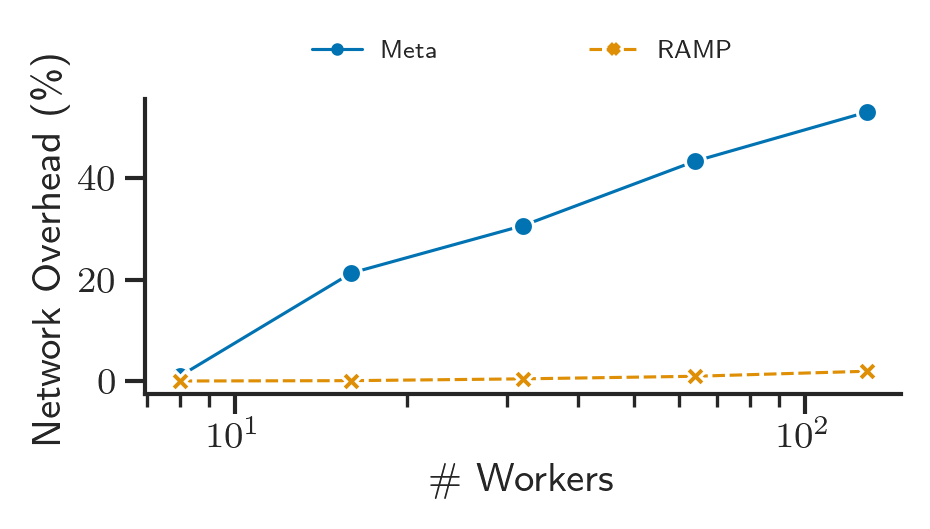

In [31]:
hue, style = 'Cluster', 'Cluster'
ylog = False
for metric in metrics:
    lineplot(df=comparison_df, metric=metric)